In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from tqdm import tqdm
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [2]:
torch.cuda.empty_cache()

In [3]:
data_dir = 'Assignment 5 Dataset'

In [4]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                        # transforms.RandomResizedCrop(224),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=validation_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=60, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=60, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


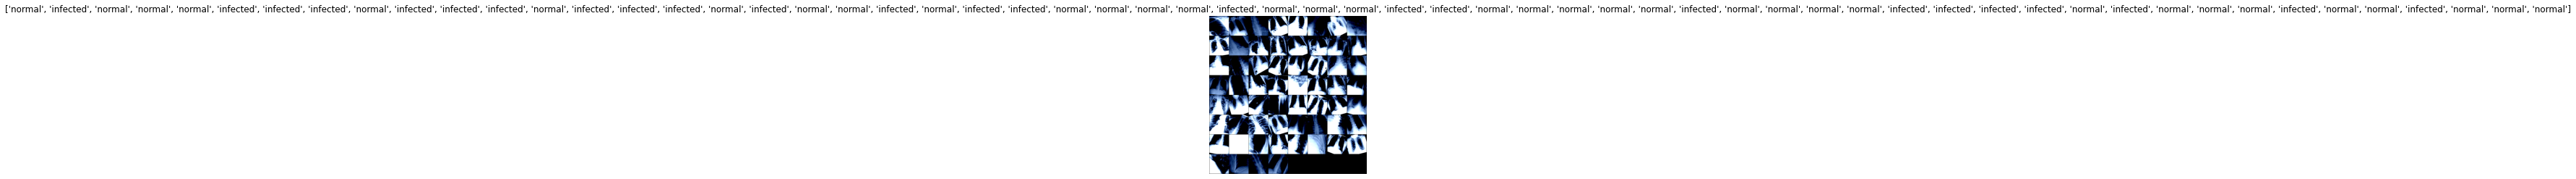

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# Task1 

## VGG-16

### Loading Model

In [6]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)


### Freezing Layers

In [7]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False 

### Modification in FC Layers


In [8]:
### Used Formula for Features

roll_num = 33
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[0:-7] # Remove last layer
# Adding Layer
features.extend([nn.Linear(num_features, ( roll_num * 10 ) + 100 )])

features.extend([nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear( (roll_num * 10 ) +100 , (roll_num * 10 ) +100 )])

features.extend([nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear( (roll_num * 10 ) +100 , (roll_num * 10 ) +100 )])

features.extend([nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear( (roll_num * 10 ) +100 , (roll_num * 10 ) +100 )])

features.extend([nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear( (roll_num * 10 ) +100 , (roll_num * 10 ) +100 )])

features.extend([nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear( (roll_num * 10 ) +100 , len(class_names) )])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss Function and Optimizer

In [10]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

### Training

In [11]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16_loss=[]
vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    vgg16_loss.append(loss.data)
        
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [11940/12000 (100%)]	Loss: 0.689780: : 200it [04:59,  1.50s/it]
Train Epoch: 1 [11940/12000 (100%)]	Loss: 0.687089: : 200it [04:57,  1.49s/it]
Train Epoch: 2 [11940/12000 (100%)]	Loss: 0.682476: : 200it [05:02,  1.51s/it]
Train Epoch: 3 [11940/12000 (100%)]	Loss: 0.671978: : 200it [05:03,  1.52s/it]
Train Epoch: 4 [11940/12000 (100%)]	Loss: 0.678617: : 200it [05:03,  1.52s/it]
Train Epoch: 5 [11940/12000 (100%)]	Loss: 0.678522: : 200it [05:04,  1.52s/it]
Train Epoch: 6 [11940/12000 (100%)]	Loss: 0.680705: : 200it [05:03,  1.52s/it]
Train Epoch: 7 [11940/12000 (100%)]	Loss: 0.669927: : 200it [05:02,  1.51s/it]
Train Epoch: 8 [11940/12000 (100%)]	Loss: 0.602913: : 200it [05:03,  1.52s/it]
Train Epoch: 9 [11940/12000 (100%)]	Loss: 0.616233: : 200it [05:04,  1.52s/it]


Finished Training


### Validation

In [12]:
valid_infected_pos = 0
valid_infected_neg = 0
valid_normal_pos = 0
valid_normal_neg = 0
count = 0
vgg16_accuracy=[]
for epoch in range(Epochs):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        for index , value in enumerate(predicted):
            if(labels[index].item() == 1):
                if(predicted[index].item() == 1):
                    valid_infected_pos += 1
                else:
                    valid_infected_neg += 1
            else:
                if(predicted[index].item() == 0):
                    valid_normal_pos += 1
                else:
                    valid_normal_neg += 1

    count=count+1
    print('Accuracy of the Validation at epoch %d : %d %%' % (++count,
      100 * correct / total))
    vgg16_accuracy.append((100 * correct / total))

Accuracy of the Validation at epoch 1 : 59 %
Accuracy of the Validation at epoch 2 : 59 %
Accuracy of the Validation at epoch 3 : 59 %
Accuracy of the Validation at epoch 4 : 59 %
Accuracy of the Validation at epoch 5 : 59 %
Accuracy of the Validation at epoch 6 : 59 %
Accuracy of the Validation at epoch 7 : 59 %
Accuracy of the Validation at epoch 8 : 59 %
Accuracy of the Validation at epoch 9 : 59 %
Accuracy of the Validation at epoch 10 : 59 %


####  Validation F1 score and Confusion Matrix

In [44]:
valid_recall = 0
valid_precision = 0 
valid_f_score = 0

valid_recall = valid_normal_pos/(valid_normal_pos+valid_infected_neg)
valid_precision = valid_normal_pos/(valid_normal_pos+valid_normal_neg)
valid_f_score = 2*(valid_precision*valid_recall)/(valid_precision+valid_recall)
print('VGG-16 Valid F1 Score: %d %%' % (100 * valid_f_score))                 
## Conusion mAtrix

data = np.array([[valid_normal_pos, valid_normal_neg],
                 [valid_infected_neg,valid_infected_pos, ]])
print("               Predicted  ")

row_format ="{:>15}" * (len(class_names) + 1)
print(row_format.format("", *class_names))
for team, row in zip(class_names, data):
    print( row_format.format(team, *row))

VGG-16 Valid F1 Score: 32 %
                    Predicted  
                      infected         normal
       infected              5           6145
         normal             14           8836


### Graphs


Cross Entropy 


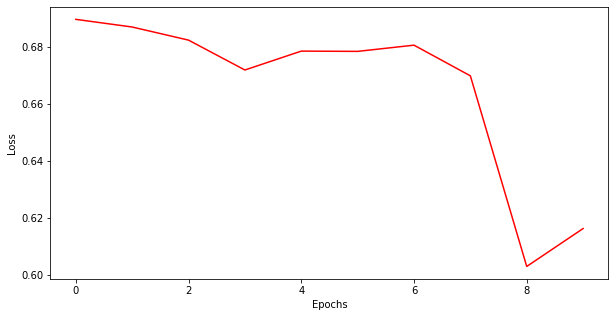

 Validation Accuracy


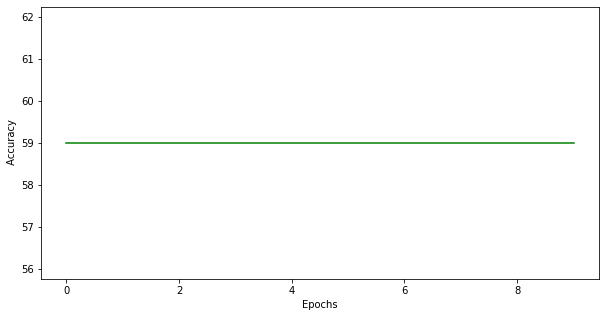

In [14]:
print('Cross Entropy ')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_loss, color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show() 

print(' Validation Accuracy')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel(' Accuracy')
plt.show()    



### Test Set

In [15]:
# Tesing VGG on Training Data
test_normal_pos = 0
test_normal_neg = 0
test_infected_pos = 0
test_infected_neg = 0

correct = 0
total = 0


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
        for index , value in enumerate(predicted):
            if(labels[index].item() == 1):
                if(predicted[index].item() == 1):
                    test_infected_pos += 1
                else:
                    test_infected_neg += 1
            else:
                if(predicted[index].item() == 0):
                    test_normal_pos += 1
                else:
                    test_normal_neg += 1
print('VGG-16 Test Accuracy: %d %%' % (100 * correct / total))   


VGG-16 Test Accuracy: 59 %


In [42]:
test_recall = 0
test_recall = 0
test_f_score = 0

test_recall = test_normal_pos/(test_normal_pos+test_infected_neg)
test_precision = test_normal_pos/(test_normal_pos+test_normal_neg)
test_f_score = 2*(test_precision*test_recall)/(test_precision+valid_recall)
print('VGG-16 Test F1 Score: %d %%' % (100 * test_f_score))                 
## Conusion mAtrix

data = np.array([[test_normal_pos, test_normal_neg],
                 [test_infected_neg,test_infected_pos]])
print("     Predicted  ")

row_format ="{:>15}" * (len(class_names) + 1)
print(row_format.format("", *class_names))
for team, row in zip(class_names, data):
    print( row_format.format(team, *row))

VGG-16 Test F1 Score: 44 %
     Predicted  
                      infected         normal
       infected              1            615
         normal              0            884


# ResNet18


In [19]:
resnet18 = models.resnet18(pretrained=True)

### Freezing Layers

In [20]:
for param in resnet18.parameters():
    param.require_grad = False

### Modifications in FC layer

In [21]:
resnet18.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(512, 430)), ('relu', nn.ReLU()), ('fc2', nn.Linear(430, 2)), ('output', nn.LogSoftmax(dim=1))]))


 ### Optimizer and Loss Function


In [22]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


### Training

In [23]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()


resnet18_loss = []

# Running Epochs
for epoch in range(Epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        resnet18_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        resnet18_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    resnet18_loss.append(loss.data)
        
    torch.save(resnet18.state_dict(), 'res18_FC_Only.pth')

Train Epoch: 0 [11940/12000 (100%)]	Loss: 0.299835: : 200it [04:07,  1.24s/it]
Train Epoch: 1 [11940/12000 (100%)]	Loss: 0.228087: : 200it [04:09,  1.25s/it]
Train Epoch: 2 [11940/12000 (100%)]	Loss: 0.280606: : 200it [04:12,  1.26s/it]
Train Epoch: 3 [11940/12000 (100%)]	Loss: 0.214333: : 200it [04:09,  1.25s/it]
Train Epoch: 4 [11940/12000 (100%)]	Loss: 0.293316: : 200it [04:09,  1.25s/it]
Train Epoch: 5 [11940/12000 (100%)]	Loss: 0.296085: : 200it [04:08,  1.24s/it]
Train Epoch: 6 [11940/12000 (100%)]	Loss: 0.158503: : 200it [04:19,  1.30s/it]
Train Epoch: 7 [11940/12000 (100%)]	Loss: 0.224194: : 200it [04:11,  1.26s/it]
Train Epoch: 8 [11940/12000 (100%)]	Loss: 0.241133: : 200it [04:06,  1.23s/it]
Train Epoch: 9 [11940/12000 (100%)]	Loss: 0.198827: : 200it [04:07,  1.24s/it]


### Validation

In [24]:
count = 0
valid_infected_pos = 0
valid_infected_neg = 0
valid_normal_pos = 0
valid_normal_neg = 0

resnet18_accuracy=[]
for epoch in range(Epochs):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        for index , value in enumerate(predicted):
            if(labels[index].item() == 1):
                if(predicted[index].item() == 1):
                    valid_infected_pos += 1
                else:
                    valid_infected_neg += 1
            else:
                if(predicted[index].item() == 0):
                    valid_normal_pos += 1
                else:
                    valid_normal_neg += 1
                    
    count=count+1
    print('Accuracy of the Validation at epoch %d : %d %%' % (++count,
      100 * correct / total))
    resnet18_accuracy.append((100 * correct / total))

Accuracy of the Validation at epoch 1 : 91 %
Accuracy of the Validation at epoch 2 : 91 %
Accuracy of the Validation at epoch 3 : 91 %
Accuracy of the Validation at epoch 4 : 90 %
Accuracy of the Validation at epoch 5 : 90 %
Accuracy of the Validation at epoch 6 : 91 %
Accuracy of the Validation at epoch 7 : 91 %
Accuracy of the Validation at epoch 8 : 91 %
Accuracy of the Validation at epoch 9 : 91 %
Accuracy of the Validation at epoch 10 : 91 %


#### Validation F1 Score and Confusion Matrix

In [25]:
valid_recall = 0
valid_precision = 0 
valid_f_score = 0

valid_recall = valid_normal_pos/(valid_normal_pos+valid_infected_neg)
valid_precision = valid_normal_pos/(valid_normal_pos+valid_normal_neg)
valid_f_score = 2*(valid_precision*valid_recall)/(valid_precision+valid_recall)
print('ResNet18 Valid F1 Score: %d %%' % (100 * valid_f_score))                 
## Conusion mAtrix

data = np.array([[valid_normal_pos, valid_normal_neg],
                 [valid_infected_neg,valid_infected_pos, ]])
print("     Predicted  ")

row_format ="{:>15}" * (len(class_names) + 1)
print(row_format.format("", *class_names))
for team, row in zip(class_names, data):
    print( row_format.format(team, *row))

ResNet18 Valid F1 Score: 89 %
     Predicted  
                      infected         normal
       infected            213             23
         normal             25            339


### Graphs

Cross Entropy 


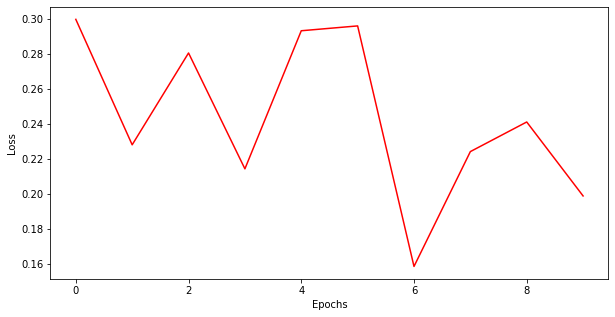

 Validation Accuracy


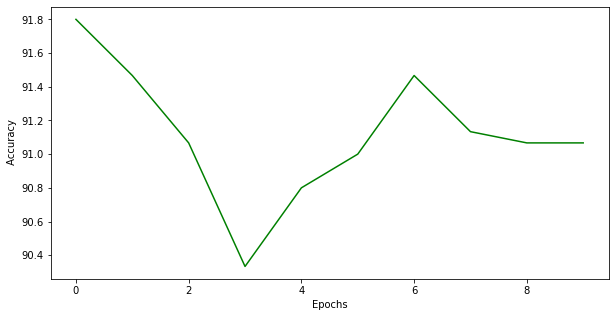

In [26]:
print('Cross Entropy ')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_loss, color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show() 

print(' Validation Accuracy')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel(' Accuracy')
plt.show()  

### Test Set

In [27]:
# Tesing ResNet18 on Training Data
test_normal_pos = 0
test_normal_neg = 0
test_infected_pos = 0
test_infected_neg = 0

correct = 0
total = 0


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
        for index , value in enumerate(predicted):
            if(labels[index].item() == 1):
                if(predicted[index].item() == 1):
                    test_infected_pos += 1
                else:
                    test_infected_neg += 1
            else:
                if(predicted[index].item() == 0):
                    test_normal_pos += 1
                else:
                    test_normal_neg += 1
print('ResNet18 Test Accuracy: %d %%' % (100 * correct / total))   


ResNet18 Test Accuracy: 96 %


In [28]:
## Confusion Matrix and F1 score


test_recall = 0
test_recall = 0
test_f_score = 0

test_recall = test_normal_pos/(test_normal_pos+test_infected_neg)
test_precision = test_normal_pos/(test_normal_pos+test_normal_neg)
test_f_score = 2*(test_precision*test_recall)/(test_precision+valid_recall)
print('ResNet18 Valid F1 Score: %d %%' % (100 * test_f_score))                 
## Conusion mAtrix

data = np.array([[test_normal_pos, test_normal_neg],
                 [test_infected_neg,test_infected_pos]])
print("     Predicted  ")

row_format ="{:>15}" * (len(class_names) + 1)
print(row_format.format("", *class_names))
for team, row in zip(class_names, data):
    print( row_format.format(team, *row))

ResNet18 Valid F1 Score: 99 %
     Predicted  
                      infected         normal
       infected            571             44
         normal             11            874


# Task2

## VGG-16

In [29]:
vgg16 = models.vgg16(pretrained=True)


### Freezing Layers

In [ ]:
# count = 0

# for param in vgg16.features.parameters():
#     if count%3 != 0:
#         param.require_grad = False
#     count += 1


### Modification in Layers

In [31]:
### Used Formula for Features

roll_num = 33
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[0:-1] 
print(features)
# Adding Layer
features.extend([nn.Linear(num_features, len(class_names) )])
vgg16.classifier = nn.Sequential(*features)


[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


### Loss Function and Optimizer

In [32]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
vgg16_optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Training

In [33]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16_loss=[]
vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    vgg16_loss.append(loss.data)
        
    torch.save(vgg16.state_dict(), 'vgg16_entire.pth')

print('Finished Training')

Train Epoch: 0 [11940/12000 (100%)]	Loss: 0.728813: : 200it [05:06,  1.53s/it]
Train Epoch: 1 [11940/12000 (100%)]	Loss: 0.714374: : 200it [05:05,  1.53s/it]
Train Epoch: 2 [11940/12000 (100%)]	Loss: 0.676746: : 200it [05:07,  1.54s/it]
Train Epoch: 3 [11940/12000 (100%)]	Loss: 0.664683: : 200it [05:03,  1.52s/it]
Train Epoch: 4 [11940/12000 (100%)]	Loss: 0.681224: : 200it [05:08,  1.54s/it]
Train Epoch: 5 [11940/12000 (100%)]	Loss: 0.607802: : 200it [05:04,  1.52s/it]
Train Epoch: 6 [11940/12000 (100%)]	Loss: 0.705856: : 200it [05:07,  1.54s/it]
Train Epoch: 7 [11940/12000 (100%)]	Loss: 0.724299: : 200it [05:01,  1.51s/it]
Train Epoch: 8 [11940/12000 (100%)]	Loss: 0.712448: : 200it [05:21,  1.61s/it]
Train Epoch: 9 [11940/12000 (100%)]	Loss: 0.675056: : 200it [05:14,  1.57s/it]

Finished Training


### Validation

In [34]:
valid_infected_pos = 0
valid_infected_neg = 0
valid_normal_pos = 0
valid_normal_neg = 0
count = 0
vgg16_accuracy=[]
for epoch in range(Epochs):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        for index , value in enumerate(predicted):
            if(labels[index].item() == 1):
                if(predicted[index].item() == 1):
                    valid_infected_pos += 1
                else:
                    valid_infected_neg += 1
            else:
                if(predicted[index].item() == 0):
                    valid_normal_pos += 1
                else:
                    valid_normal_neg += 1

    count=count+1
    print('Accuracy of the Validation at epoch %d : %d %%' % (++count,
      100 * correct / total))
    vgg16_accuracy.append((100 * correct / total))

Accuracy of the Validation at epoch 1 : 57 %
Accuracy of the Validation at epoch 2 : 57 %
Accuracy of the Validation at epoch 3 : 58 %
Accuracy of the Validation at epoch 4 : 58 %
Accuracy of the Validation at epoch 5 : 58 %
Accuracy of the Validation at epoch 6 : 58 %
Accuracy of the Validation at epoch 7 : 58 %
Accuracy of the Validation at epoch 8 : 59 %
Accuracy of the Validation at epoch 9 : 58 %
Accuracy of the Validation at epoch 10 : 59 %


#### Validation F1 Score and Confusion Matrix

In [35]:
valid_recall = 0
valid_precision = 0 
valid_f_score = 0

valid_recall = valid_normal_pos/(valid_normal_pos+valid_infected_neg)
valid_precision = valid_normal_pos/(valid_normal_pos+valid_normal_neg)
valid_f_score = 2*(valid_precision*valid_recall)/(valid_precision+valid_recall)
print('VGG-16 Valid F1 Score: %d %%' % (100 * valid_f_score))                 
## Conusion mAtrix

data = np.array([[valid_normal_pos, valid_normal_neg],
                 [valid_infected_neg,valid_infected_pos, ]])
print("     Predicted  ")

row_format ="{:>15}" * (len(class_names) + 1)
print(row_format.format("", *class_names))
for team, row in zip(class_names, data):
    print( row_format.format(team, *row))

VGG-16 Valid F1 Score: 23 %
     Predicted  
                      infected         normal
       infected             41            221
         normal             50            288


### Graphs


Cross Entropy 


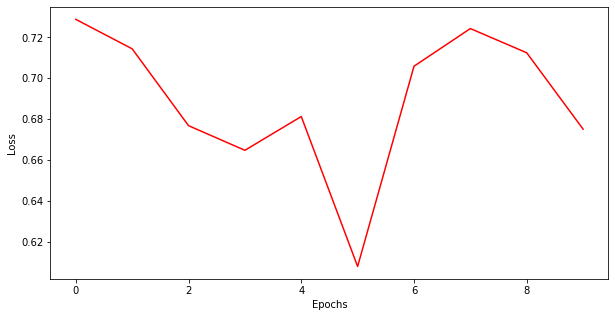

 Validation Accuracy


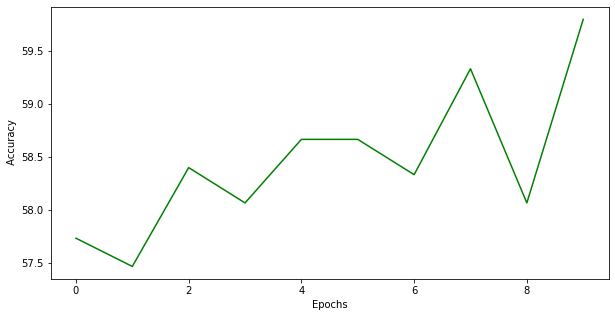

In [36]:
print('Cross Entropy ')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_loss, color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show() 

print(' Validation Accuracy')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), vgg16_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel(' Accuracy')
plt.show()    



### Test DataSet

In [37]:
# Tesing VGG on Training Data
test_normal_pos = 0
test_normal_neg = 0
test_infected_pos = 0
test_infected_neg = 0

correct = 0
total = 0


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
        for index , value in enumerate(predicted):
            if(labels[index].item() == 1):
                if(predicted[index].item() == 1):
                    test_infected_pos += 1
                else:
                    test_infected_neg += 1
            else:
                if(predicted[index].item() == 0):
                    test_normal_pos += 1
                else:
                    test_normal_neg += 1
print('VGG-16 Test Accuracy: %d %%' % (100 * correct / total))   


VGG-16 Test Accuracy: 59 %


In [38]:
test_recall = 0
test_recall = 0
test_f_score = 0

test_recall = test_normal_pos/(test_normal_pos+test_infected_neg)
test_precision = test_normal_pos/(test_normal_pos+test_normal_neg)
test_f_score = 2*(test_precision*test_recall)/(test_precision+valid_recall)
print('VGG-16 Valid F1 Score: %d %%' % (100 * test_f_score))                 
## Conusion mAtrix

data = np.array([[test_normal_pos, test_normal_neg],
                 [test_infected_neg,test_infected_pos]])
print("     Predicted  ")

row_format ="{:>15}" * (len(class_names) + 1)
print(row_format.format("", *class_names))
for team, row in zip(class_names, data):
    print( row_format.format(team, *row))

VGG-16 Valid F1 Score: 32 %
     Predicted  
                      infected         normal
       infected            127            488
         normal            122            763


# ResNet18

In [45]:
resnet18 = models.resnet18(pretrained=True)

### Freezing Layers

In [ ]:
# # Freeze training for all layers
# for param in vgg16.features.parameters():
#     param.require_grad = False 

### Modifications in FC layer

In [46]:
resnet18.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(512, len(class_names)))]))


 ### Optimizer and Loss Function


In [47]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


### Training

In [48]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()


resnet18_loss = []

# Running Epochs
for epoch in range(Epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        resnet18_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        resnet18_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    resnet18_loss.append(loss.data)
        
    torch.save(resnet18.state_dict(), 'res18_entire.pth')

Train Epoch: 0 [11940/12000 (100%)]	Loss: 0.243051: : 200it [04:18,  1.29s/it]
Train Epoch: 1 [11940/12000 (100%)]	Loss: 0.215474: : 200it [04:05,  1.23s/it]
Train Epoch: 2 [11940/12000 (100%)]	Loss: 0.139429: : 200it [04:06,  1.23s/it]
Train Epoch: 3 [11940/12000 (100%)]	Loss: 0.187983: : 200it [04:05,  1.23s/it]
Train Epoch: 4 [11940/12000 (100%)]	Loss: 0.174817: : 200it [04:05,  1.23s/it]
Train Epoch: 5 [11940/12000 (100%)]	Loss: 0.179258: : 200it [04:10,  1.25s/it]
Train Epoch: 6 [11940/12000 (100%)]	Loss: 0.179001: : 200it [04:13,  1.27s/it]
Train Epoch: 7 [11940/12000 (100%)]	Loss: 0.165570: : 200it [04:11,  1.26s/it]
Train Epoch: 8 [11940/12000 (100%)]	Loss: 0.174801: : 200it [04:10,  1.25s/it]
Train Epoch: 9 [11940/12000 (100%)]	Loss: 0.099352: : 200it [04:15,  1.28s/it]


## Validation

In [49]:
count = 0
valid_infected_pos = 0
valid_infected_neg = 0
valid_normal_pos = 0
valid_normal_neg = 0

resnet18_accuracy=[]
for epoch in range(Epochs):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        for index , value in enumerate(predicted):
            if(labels[index].item() == 1):
                if(predicted[index].item() == 1):
                    valid_infected_pos += 1
                else:
                    valid_infected_neg += 1
            else:
                if(predicted[index].item() == 0):
                    valid_normal_pos += 1
                else:
                    valid_normal_neg += 1
                    
    count=count+1
    print('Accuracy of the Validation at epoch %d : %d %%' % (++count,
      100 * correct / total))
    resnet18_accuracy.append((100 * correct / total))

Accuracy of the Validation at epoch 1 : 90 %
Accuracy of the Validation at epoch 2 : 90 %
Accuracy of the Validation at epoch 3 : 91 %
Accuracy of the Validation at epoch 4 : 91 %
Accuracy of the Validation at epoch 5 : 91 %
Accuracy of the Validation at epoch 6 : 91 %
Accuracy of the Validation at epoch 7 : 91 %
Accuracy of the Validation at epoch 8 : 91 %
Accuracy of the Validation at epoch 9 : 91 %
Accuracy of the Validation at epoch 10 : 91 %


#### Validation F1 Score and Confusion Matrix

In [50]:
valid_recall = 0
valid_precision = 0 
valid_f_score = 0

valid_recall = valid_normal_pos/(valid_normal_pos+valid_infected_neg)
valid_precision = valid_normal_pos/(valid_normal_pos+valid_normal_neg)
valid_f_score = 2*(valid_precision*valid_recall)/(valid_precision+valid_recall)
print('ResNet18 Valid F1 Score: %d %%' % (100 * valid_f_score))                 
## Conusion mAtrix

data = np.array([[valid_normal_pos, valid_normal_neg],
                 [valid_infected_neg,valid_infected_pos, ]])
print("     Predicted  ")

row_format ="{:>15}" * (len(class_names) + 1)
print(row_format.format("", *class_names))
for team, row in zip(class_names, data):
    print( row_format.format(team, *row))

ResNet18 Valid F1 Score: 89 %
     Predicted  
                      infected         normal
       infected            208             25
         normal             24            343


### Graphs

Cross Entropy 


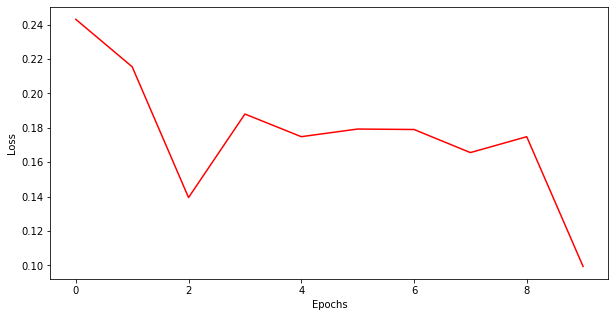

 Validation Accuracy


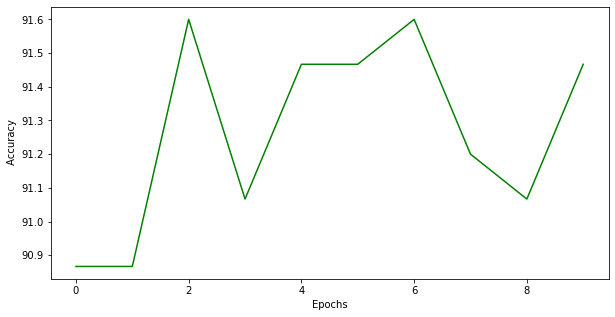

In [51]:
print('Cross Entropy ')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_loss, color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show() 

print(' Validation Accuracy')
plt.figure(figsize=(10,5))
plt.plot(range(Epochs), resnet18_accuracy, color='green')
plt.xlabel('Epochs')
plt.ylabel(' Accuracy')
plt.show()  

### Test Set

In [52]:
# Tesing ResNet18 on Training Data
test_normal_pos = 0
test_normal_neg = 0
test_infected_pos = 0
test_infected_neg = 0

correct = 0
total = 0


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
        for index , value in enumerate(predicted):
            if(labels[index].item() == 1):
                if(predicted[index].item() == 1):
                    test_infected_pos += 1
                else:
                    test_infected_neg += 1
            else:
                if(predicted[index].item() == 0):
                    test_normal_pos += 1
                else:
                    test_normal_neg += 1
print('ResNet18 Test Accuracy: %d %%' % (100 * correct / total))   


ResNet18 Test Accuracy: 96 %


In [53]:
## Confusion Matrix and F1 score


test_recall = 0
test_recall = 0
test_f_score = 0

test_recall = test_normal_pos/(test_normal_pos+test_infected_neg)
test_precision = test_normal_pos/(test_normal_pos+test_normal_neg)
test_f_score = 2*(test_precision*test_recall)/(test_precision+valid_recall)
print('ResNet18 Test F1 Score: %d %%' % (100 * test_f_score))                 
## Conusion mAtrix

data = np.array([[test_normal_pos, test_normal_neg],
                 [test_infected_neg,test_infected_pos]])
print("     Predicted  ")

row_format ="{:>15}" * (len(class_names) + 1)
print(row_format.format("", *class_names))
for team, row in zip(class_names, data):
    print( row_format.format(team, *row))

ResNet18 Test F1 Score: 100 %
     Predicted  
                      infected         normal
       infected            578             37
         normal              9            876
